# chainerでAutoEncoderのテストをする

In [2]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

import six

import matplotlib.pyplot as plt

import data

## GPU設定

In [3]:
gpu_flag = 0

In [4]:
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## MNISTデータのダウンロード
* 28×28ピクセル、[0,1]の値に変換

In [5]:
mnist = data.load_mnist_data()


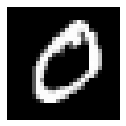

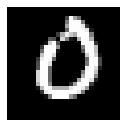

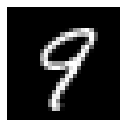

In [6]:
# 手書き数字データを描画する関数
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2, 2))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

draw_digit(mnist['data'][1])
draw_digit(mnist['data'][192])
draw_digit(mnist['data'][3099])

### 前処理

In [7]:
# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
mnist_data = mnist['data'].astype(xp.float32) / 255.0

x_train, x_test = np.split(mnist_data,   [N])
#y_train, y_test = np.split(mnist['target'], [N])
y_train, y_test = np.split(mnist_data.copy(),   [N])
## AEなので、教師信号は入力と同じ
N_test = y_test.size


## モデルの定義

In [8]:
class AE(Chain):
    def __init__(self, m_units):
        super(AE, self).__init__(
            lin1=F.Linear(784, m_units),
            lin2=F.Linear(m_units, 784),
        )
        
    def __call__(self, x, train=True):
        # chainの定義
        h = F.dropout(F.relu(self.lin1(x)), ratio=0.5, train=train)
        #y = F.dropout(F.relu(self.lin2(h)), ratio=0.5, train=train)
        y = F.dropout(self.lin2(h), ratio=0.5, train=train)
        return y

## Chainの定義

In [9]:
class Forward_AE(Chain):
    def __init__(self, predictor):
        super(Forward_AE, self).__init__(predictor=predictor)
    
    def __call__(self, x, t, train=True):
        y = self.predictor(x, train)
        self.loss = F.mean_squared_error(y, t)
        return self.loss, y

## Optimizerの定義

In [10]:
middle_units = 300
model = Forward_AE(AE(middle_units))

if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()

## SGDでは全く学習が進まなかった 
## lossは下がるのに
optimizer = optimizers.Adam()
optimizer.setup(model)

## 学習

In [11]:
batchsize = 100
epochN = 20
datasize = N

In [12]:
loss_arr = []
print('epoch \t loss')
for epoch in range(epochN):
    sum_loss=0
    sum_accuracy = 0
    indexes = np.random.permutation(datasize)
    for i in six.moves.range(0, datasize, batchsize):
        x = Variable(xp.asarray(x_train[indexes[i : i + batchsize]]))
        t = Variable(xp.asarray(y_train[indexes[i : i + batchsize]]))
        
        model.zerograds()
        loss, y = model(x, t)
        loss.backward()
        optimizer.update()
        
        sum_loss += loss.data * len(t.data)
    print('%s \t %s'%(epoch, sum_loss/datasize))
    loss_arr.append(float(sum_loss)/datasize)

epoch 	 loss
0 	 0.0880962312222
1 	 0.0826199054718
2 	 0.0816090032458
3 	 0.0809677615762
4 	 0.0807835608721
5 	 0.0804080367088
6 	 0.0801060572267
7 	 0.0798746794462
8 	 0.0795600861311
9 	 0.0792659148574
10 	 0.0792133063078
11 	 0.0790646672249
12 	 0.0789942070842
13 	 0.0788563489914
14 	 0.0788112208247
15 	 0.0788170471787
16 	 0.0788240581751
17 	 0.0788262635469
18 	 0.0788735449314
19 	 0.0787706598639


[]

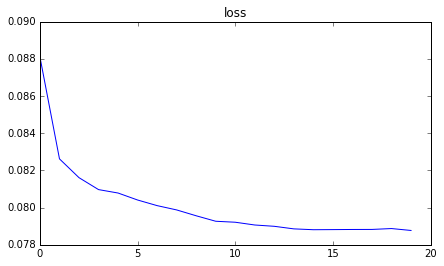

In [13]:
plt.figure(figsize=(7,4))

plt.plot(range(len(loss_arr)), loss_arr, color="#0000FF")
#plt.legend(["loss"],loc=4)
plt.title("loss")

plt.plot()

## 結果の可視化

In [14]:
TN = 10
x_test=x_test.astype(xp.float32)
#x_test = x_train
test = Variable(xp.asarray(x_test[:TN]))
los, y = model(test, test, train=False)


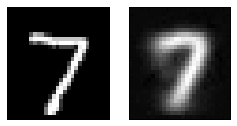

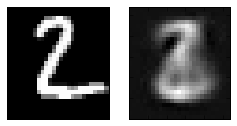

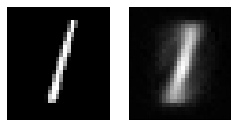

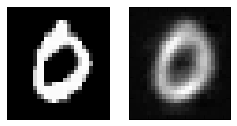

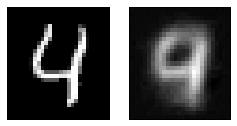

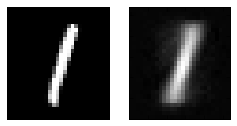

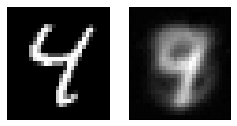

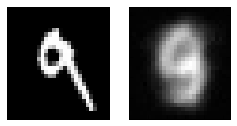

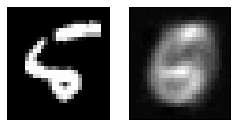

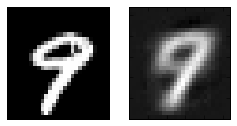

In [15]:
for i in np.arange(0,TN):
    draw_digit_ae(x_test[i], y.data[i].get())

In [1]:
def draw_digit_ae(data, data_):
    size = 28
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    
    plt.subplot(1, 2, 2)
    Z = data_.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()